In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from torchinfo import summary
from adopt import ADOPT

In [75]:
data = pd.read_csv("data/data1003.csv")

In [76]:
print(f"The number of features available to us: {data.shape[1]}")
print(data.head(0))

The number of features available to us: 62
Empty DataFrame
Columns: [Unnamed: 0, time, DLWRF_surface, PRES_surface, SPFH_2maboveground, precip_rate, DSWRF_surface, TMP_2maboveground, UGRD_10maboveground, VGRD_10maboveground, APCP_surface, streamflow, elevation_mean, slope_mean, impervious_mean, aspect_c_mean, twi_dist_4, X, Y, gw_Coeff, gw_Zmax, gw_Expon, bexp_soil_layers_stag=1, bexp_soil_layers_stag=2, bexp_soil_layers_stag=3, bexp_soil_layers_stag=4, ISLTYP, IVGTYP, dksat_soil_layers_stag=1, dksat_soil_layers_stag=2, dksat_soil_layers_stag=3, dksat_soil_layers_stag=4, psisat_soil_layers_stag=1, psisat_soil_layers_stag=2, psisat_soil_layers_stag=3, psisat_soil_layers_stag=4, cwpvt, mfsno, mp, quartz_soil_layers_stag=1, quartz_soil_layers_stag=2, quartz_soil_layers_stag=3, quartz_soil_layers_stag=4, refkdt, slope, smcmax_soil_layers_stag=1, smcmax_soil_layers_stag=2, smcmax_soil_layers_stag=3, smcmax_soil_layers_stag=4, smcwlt_soil_layers_stag=1, smcwlt_soil_layers_stag=2, smcwlt_soil

In [77]:
def load_data_in_dictionary(data):
    '''This loads the data into a dictionary. each index of dictionary has a pair of watersheds, 
       upper and lower, and their features are merged in the for loop below'''
    num_networks = 0
    network_dict = {}
    broken_pairs = []
    for i in range(int((data['pair_id']).max())+1):
        try:
            downstream = data[(data['pair_id']== i) & (data['du'] == 'd')]
            upstream = data[(data['pair_id']== i) & (data['du'] == 'u')]
            #print(downstream)
            #print(upstream)
            if downstream.empty or downstream.isnull().values.any():
                print(i, " DS is empty")
                continue
            if upstream.empty or upstream.isnull().values.any():
                print(i, " US is empty")
                continue
            '''area_ratio = upstream.iloc[0]["Shape_Area"] / downstream.iloc[0]["Shape_Area"]
            if area_ratio > 1:
                print(i, " area ratio too large")
                continue
            if abs(downstream.iloc[-1]['ID'] - upstream.iloc[-1]['ID']) > 100:
                print(i, " DS and US too far apart")
                continue'''
            network = downstream.merge(upstream, on="time")
            network.drop(["x_x", "y_x", "pair_id_x", "x_y", "y_y", "pair_id_y"], axis=1, inplace=True)
            network_dict[num_networks] = network
            num_networks += 1
        except:
            broken_pairs.append(i)
            raise Exception
    return network_dict, broken_pairs, num_networks



network_dict, num_networks, broken_pairs = load_data_in_dictionary(data)

print(f"The number of networks we have:\t{len(network_dict)}")
print(f"The number of data points in each network:\t{network_dict[0].shape[0]}")
print(f"The number of features in each network:\t{network_dict[0].shape[1]}")

The number of networks we have:	7
The number of data points in each network:	696
The number of features in each network:	117


In [78]:
def correlation_with_lstm_output(correlation_inputs, correlation_outputs):
    correlation_data = correlation_inputs + correlation_outputs
    frames = [network_dict[ibuc].loc[:, correlation_data] for ibuc in [0,1,5,6]]
    df_in = pd.concat(frames)
    correlation_matrix = np.corrcoef(df_in)

    for i in range(len(correlation_outputs)):
        print(f"Correlation with {correlation_outputs[i]}")
        for j in range(len(correlation_data)):
            print(f"{correlation_data[j]}: {correlation_matrix[i+len(correlation_inputs)][j]}")



In [79]:
#among all the features in the dataset, we will be working on thses features. If you want to add a new feature, see the datafile and add features as you like

lstm_inputs = [
    'precip_rate_x', 
    'TMP_2maboveground_x', 
    'UGRD_10maboveground_x',
    'APCP_surface_x', 
    'elevation_mean_x', 'slope_mean_x', 'Shape_Area_x',
    'impervious_mean_x', 'dksat_soil_layers_stag=1_x', 
    'streamflow_x',
    'precip_rate_y', 
    'TMP_2maboveground_y', 
    'UGRD_10maboveground_y',
    'APCP_surface_y', 
    'elevation_mean_y', 'slope_mean_y', 'Shape_Area_y',
    'impervious_mean_y', 'dksat_soil_layers_stag=1_y']


n_input = len(lstm_inputs)

lstm_outputs = ['streamflow_y']     #this is what we will be trying to predict using the LSTM model
n_output = len(lstm_outputs)
print(f"The number of features for LSTM model:\t{n_input}")

The number of features for LSTM model:	19


In [80]:
correlation_inputs = [
    # 'precip_rate_x', 
    'APCP_surface_x', 
               'TMP_2maboveground_x', 
    'DSWRF_surface_x', 'DLWRF_surface_x', 'PRES_surface_x', 
    'UGRD_10maboveground_x', 'VGRD_10maboveground_x', 'SPFH_2maboveground_x', 
    'elevation_mean_x', 'slope_mean_x', 'Shape_Area_x',
    'impervious_mean_x', 'dksat_soil_layers_stag=1_x', 
    'streamflow_x',
    # 'precip_rate_y', 
    'APCP_surface_y', 
    'TMP_2maboveground_y',
    'DSWRF_surface_y', 'DLWRF_surface_y', 'PRES_surface_y',
    'UGRD_10maboveground_y', 'VGRD_10maboveground_y', 'SPFH_2maboveground_y',
    'elevation_mean_y', 'slope_mean_y', 'Shape_Area_y',
    'impervious_mean_y', 'dksat_soil_layers_stag=1_y']

correlation_with_lstm_output(correlation_inputs, lstm_outputs)

Correlation with streamflow_y
APCP_surface_x: 0.9999999747385039
TMP_2maboveground_x: 0.9999999775523916
DSWRF_surface_x: 0.9999999790033776
DLWRF_surface_x: 0.9999999988281622
PRES_surface_x: 0.9999999986065536
UGRD_10maboveground_x: 0.9999999993743482
VGRD_10maboveground_x: 0.9999999930775616
SPFH_2maboveground_x: 0.9999999929204678
elevation_mean_x: 0.9999999932876569
slope_mean_x: 0.9999999802979805
Shape_Area_x: 0.999999980020199
impervious_mean_x: 0.9999999794893975
dksat_soil_layers_stag=1_x: 0.9999998947844357
streamflow_x: 0.9999975569998939
APCP_surface_y: 0.999992221109325
TMP_2maboveground_y: 0.9999835983734059
DSWRF_surface_y: 0.9999742449158907
DLWRF_surface_y: 0.9999676163799787
PRES_surface_y: 0.9999633792254142
UGRD_10maboveground_y: 0.9999654934975047
VGRD_10maboveground_y: 0.9999723923416026
SPFH_2maboveground_y: 0.9999823704574873
elevation_mean_y: 0.9999922738661662
slope_mean_y: 0.9999977422811037
Shape_Area_y: 0.9999999905535563
impervious_mean_y: 0.9999999941065

In [81]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA device:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple M3/M2/M1 (Metal) device")
else:
    device = 'cpu'
    print("Using CPU")

batch_size = 1704
seq_length = 270

Using CUDA device: NVIDIA A100-SXM4-40GB


In [82]:
n_networks = len(network_dict)

n_networks_split = {"train": (math.floor(n_networks * 0.7)), "val": math.floor(n_networks * 0.2), "test": math.floor(n_networks * 0.1)}
print(n_networks_split['val'])

1


In [83]:
def split_parameters(n_networks):
    # create lists of network indices for each set based on the given network splits
    networks_for_training = list(range(0, n_networks_split['train'] + 1))
    networks_for_val = list(range(n_networks_split['train'] + 1, 
                                 n_networks_split['train'] + n_networks_split['val'] + 1))

    if (n_networks_split['test'] > 0):
        networks_for_test = list(range(n_networks - n_networks_split['test'], n_networks))
    else:
        print("Since the dataset is small and no basins are available for testing. We give a random bucket to test.")
        random_bucket = np.random.randint(0, n_networks)
        networks_for_test = [random_bucket]
    
    # organize the split parameters into separate lists for each set
    train_split_parameters = [networks_for_training]
    val_split_parameters = [networks_for_val]
    test_split_parameters = [networks_for_test]

    return [train_split_parameters, val_split_parameters, test_split_parameters]

[[networks_for_training], [networks_for_val], [networks_for_test]] = split_parameters(n_networks)
print(f"The networks for training is {networks_for_training}")
print(f"The networks for validation is {networks_for_val}")
print(f"The networks testing is {networks_for_test}")

Since the dataset is small and no basins are available for testing. We give a random bucket to test.
The networks for training is [0, 1, 2, 3, 4]
The networks for validation is [5]
The networks testing is [5]


In [84]:
def viz_networks(ibuc):
    fig, ax = plt.subplots()
    print('Network:', ibuc)
    print("Streamflow (downstream) mean:", np.round(network_dict[ibuc].streamflow_x.mean(),2))
    print("Streamflow (upstream) mean:", np.round(network_dict[ibuc].streamflow_y.mean(),2))

    # network_dict[ibuc].loc[:2000,['precip_rate_x']].plot(ax=ax, legend=False)
    network_dict[ibuc].loc[:2000,['streamflow_y']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['APCP_surface_y']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['streamflow_x']].plot(ax=ax, legend=False)
    # network_dict[ibuc].loc[:2000,['APCP_surface_x']].plot(ax=ax, legend=False)
    ax.set_title('Streamflow')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Streamflow')

    ax.legend(["Streamflow_y", "APCP_surface_x"])
    
    # plt.show()
    plt.close()

def viz_networks2(ibuc):
    fig, ax1 = plt.subplots()
    print('Network:', ibuc)
    print("Streamflow (downstream) mean:", np.round(network_dict[ibuc].streamflow_x.mean(), 2))
    print("Streamflow (upstream) mean:", np.round(network_dict[ibuc].streamflow_y.mean(), 2))

    # Plot streamflow_y on the primary y-axis
    network_dict[ibuc].loc[:2000, ['streamflow_x']].plot(ax=ax1, color = 'blue', legend=False)
    network_dict[ibuc].loc[:2000, ['streamflow_y']].plot(ax=ax1, color = 'purple', legend=False)
    ax1.set_title('Streamflow and Precipitation')
    ax1.set_xlabel('Time (h)')
    ax1.set_ylabel('Streamflow')
    
    # Create a secondary y-axis and plot APCP_surface_x on it
    ax2 = ax1.twinx()
    network_dict[ibuc].loc[:2000, ['APCP_surface_x']].plot(ax=ax2, color='orange', legend=False)
    
    network_dict[ibuc].loc[:2000, ['APCP_surface_y']].plot(ax=ax2, color='red', legend=False)
    ax2.set_ylabel('APCP Surface')
    
    # Add legends for each axis
    ax1.legend(["Streamflow_y"], loc='upper left')
    ax2.legend(["APCP_surface_x"], loc='upper right')
    
    # plt.show()
    plt.close()

    

displayed = 0

for ibuc in networks_for_training:
    viz_networks(ibuc)
    displayed += 1


for ibuc in networks_for_val:
    viz_networks(ibuc)
    displayed += 1

Network: 0
Streamflow (downstream) mean: 0.42
Streamflow (upstream) mean: 0.42
Network: 1
Streamflow (downstream) mean: 0.06
Streamflow (upstream) mean: 0.13
Network: 2
Streamflow (downstream) mean: 0.09
Streamflow (upstream) mean: 0.12
Network: 3
Streamflow (downstream) mean: 0.28
Streamflow (upstream) mean: 0.29
Network: 4
Streamflow (downstream) mean: 0.48
Streamflow (upstream) mean: 2.11
Network: 5
Streamflow (downstream) mean: 0.55
Streamflow (upstream) mean: 0.63


In [85]:


class LSTM1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size

        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.relu2 = nn.ReLU()
        self.normalization1 = nn.BatchNorm1d(256)
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(256, 128, bias=True),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64, bias = True),
            nn.ReLU(),
            nn.Linear(64, num_classes, bias=True)
        )

    def forward(self, x):
        out, _= self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.relu2(out)
        out = out[:,-1, :]
        out = self.normalization1(out)

        prediction = self.fc(out)
        return prediction



In [86]:

model = LSTM1(input_size=n_input, num_classes=n_output).to(device)

In [87]:
def fit_scaler():
    frames = [network_dict[ibuc].loc[:, lstm_inputs] for ibuc in networks_for_training]
    df_in = pd.concat(frames)   
    print(df_in.shape)
    scaler_in = StandardScaler()
    scaler_in.fit(df_in)

    frames = [network_dict[ibuc].loc[:, lstm_outputs] for ibuc in networks_for_training]
    df_out = pd.concat(frames)    
    print(df_out.shape)
    scaler_out = StandardScaler()
    scaler_out.fit(df_out)
    return scaler_in, scaler_out

In [88]:
scaler_in, scaler_out = fit_scaler()

(3480, 19)
(3480, 1)


In [89]:
def make_data_loader(network_list):
    loader = {}
    np_seq_X = {}
    np_seq_y = {}
    for ibuc in network_list:
        df = network_dict[ibuc]
        scaler_in_i = scaler_in.transform(df.loc[:, lstm_inputs])
        scaler_out_i = scaler_out.transform(df.loc[:, lstm_outputs])
        
        n_samples = scaler_in_i.shape[0] - seq_length
        
        np_seq_X[ibuc] = np.zeros((n_samples, seq_length, n_input))
        np_seq_y[ibuc] = np.zeros((n_samples, n_output)) 

        for i in range(n_samples):
            t = i + seq_length
            np_seq_X[ibuc][i, :, :] = scaler_in_i[i:t, :]
            np_seq_y[ibuc][i, :] = scaler_out_i[t, :]

        ds = [torch.Tensor(np_seq_X[ibuc]), torch.Tensor(np_seq_y[ibuc])]
        loader[ibuc] = ds
    return loader, np_seq_X, np_seq_y

In [90]:
train_loader, np_train_seq_X, np_train_seq_y = make_data_loader([0,1,5,6])
val_loader, np_val_seq_X, np_val_seq_y = make_data_loader(networks_for_val)
test_loader, np_test_seq_X, np_test_seq_y = make_data_loader(networks_for_test)

In [91]:
# print(train_loader[0][0].shape)
print(f"Each network has {train_loader[0][0].shape[0]} data points")
print(f"Each data point is made up of sequence of {train_loader[0][0].shape[1]} timesteps")
print(f"Each time step has {train_loader[0][0].shape[2]} features.")

Each network has 426 data points
Each data point is made up of sequence of 270 timesteps
Each time step has 19 features.


In [92]:
def concatanate_tensors(loader,  networks):
    concatanated_tensor_x = loader[networks[0]][0]
    concatanated_tensor_y = loader[networks[0]][1]

    for i in range(len(networks) - 1):
        concatanated_tensor_x = torch.cat((concatanated_tensor_x, loader[networks[i+1]][0]))
        concatanated_tensor_y = torch.cat((concatanated_tensor_y, loader[networks[i+1]][1]))
    return concatanated_tensor_x, concatanated_tensor_y    

  

In [93]:

train_data_x, train_data_y = concatanate_tensors(train_loader, [0,1,5,6])
val_data_x, val_data_y = concatanate_tensors(val_loader, networks_for_val)
test_data_x, test_data_y = concatanate_tensors(test_loader, networks_for_test)

In [94]:
batch_size = train_data_y.shape[0]
train_dataset = torch.utils.data.TensorDataset(train_data_x, train_data_y)
train_batch_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size)
val_dataset = torch.utils.data.TensorDataset(val_data_x, val_data_y)
val_batch_loader = torch.utils.data.DataLoader(val_dataset, batch_size= batch_size)
test_dataset = torch.utils.data.TensorDataset(test_data_x, test_data_y)
test_batch_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size)
print(f"Since each epoch will only have 1 batch of data, the batch size is set to the length of the entire data, which is {batch_size}.")

Since each epoch will only have 1 batch of data, the batch size is set to the length of the entire data, which is 1704.


In [ ]:
def train_model(lstm, train_batch_loader):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(lstm.parameters(), lr= .0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)
    epochs = 200
    loss_history = []
    for epoch in range(epochs):
        for data, targets in train_batch_loader:
            x = data.to(device=device)
            y = targets.to(device=device)

            optimizer.zero_grad()
            predicted_y = lstm(x)
            loss = criterion(predicted_y, y)

            loss_history.append(loss.item())

            loss.backward()
            optimizer.step()
            scheduler.step(loss)

        print(f"Epoch: {epoch + 1} Completed\tLoss: {round(loss_history[-1], 4)}")

    return lstm, loss_history

In [96]:
model, results = train_model(model, train_batch_loader)

Epoch: 1 Completed	Loss: 0.2802
Epoch: 2 Completed	Loss: 0.2327
Epoch: 3 Completed	Loss: 0.2046
Epoch: 4 Completed	Loss: 0.1854
Epoch: 5 Completed	Loss: 0.1715
Epoch: 6 Completed	Loss: 0.1601
Epoch: 7 Completed	Loss: 0.1501
Epoch: 8 Completed	Loss: 0.1423
Epoch: 9 Completed	Loss: 0.1368
Epoch: 10 Completed	Loss: 0.132
Epoch: 11 Completed	Loss: 0.1277
Epoch: 12 Completed	Loss: 0.124
Epoch: 13 Completed	Loss: 0.1205
Epoch: 14 Completed	Loss: 0.1173
Epoch: 15 Completed	Loss: 0.1145
Epoch: 16 Completed	Loss: 0.1118
Epoch: 17 Completed	Loss: 0.1092
Epoch: 18 Completed	Loss: 0.107
Epoch: 19 Completed	Loss: 0.1047
Epoch: 20 Completed	Loss: 0.1023
Epoch: 21 Completed	Loss: 0.0999
Epoch: 22 Completed	Loss: 0.0976
Epoch: 23 Completed	Loss: 0.0953
Epoch: 24 Completed	Loss: 0.0931
Epoch: 25 Completed	Loss: 0.0911
Epoch: 26 Completed	Loss: 0.0891
Epoch: 27 Completed	Loss: 0.0872
Epoch: 28 Completed	Loss: 0.0853
Epoch: 29 Completed	Loss: 0.0835
Epoch: 30 Completed	Loss: 0.0818
Epoch: 31 Completed	Lo

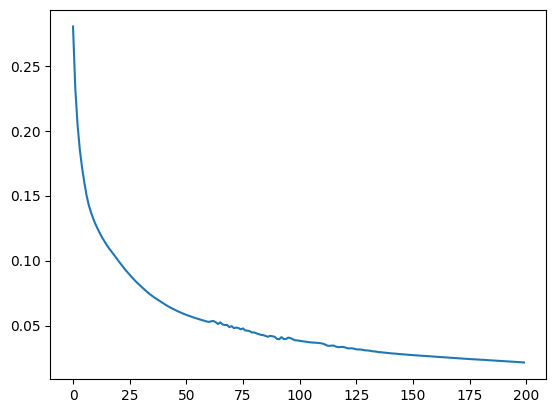

In [97]:
plt.plot([i for i in range(len(results))], results)
plt.show()

In [98]:
print(results[-100:])

[0.038321562111377716, 0.03801251947879791, 0.037746600806713104, 0.037501491606235504, 0.03723093867301941, 0.037018854171037674, 0.03692130371928215, 0.036833256483078, 0.036693572998046875, 0.03649779036641121, 0.03619653731584549, 0.03561975061893463, 0.03474067524075508, 0.034315332770347595, 0.03461811691522598, 0.03459050506353378, 0.0338624082505703, 0.033352889120578766, 0.033456578850746155, 0.033588822931051254, 0.033205389976501465, 0.03260558098554611, 0.032447341829538345, 0.03252982348203659, 0.03219246864318848, 0.03171012923121452, 0.03160402551293373, 0.03154968470335007, 0.031286463141441345, 0.03092098794877529, 0.030842749401926994, 0.030635830014944077, 0.030264142900705338, 0.030127322301268578, 0.02988918498158455, 0.02952945977449417, 0.029461167752742767, 0.0292622372508049, 0.029002320021390915, 0.028903018683195114, 0.02865743823349476, 0.02850501984357834, 0.028427286073565483, 0.028235651552677155, 0.02811218798160553, 0.027951626107096672, 0.0277219992130

In [148]:
test_data_x, test_data_y = concatanate_tensors(train_loader, [1])
test_dataset = torch.utils.data.TensorDataset(test_data_x, test_data_y)
test_batch_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size)

In [146]:

model.eval()
with torch.no_grad():
    test_data_x = test_data_x.to(device)

    predicted_y_untransformed = model(test_data_x)
    predicted_y_untransformed = predicted_y_untransformed.to("cpu").numpy()
    predicted_y = scaler_out.inverse_transform(predicted_y_untransformed)
    test_data_y = test_data_y.to("cpu").numpy()
    test_data_y = scaler_out.inverse_transform(test_data_y)


In [149]:
x = []
test_data_y = test_data_y.reshape(test_data_y.shape[0])
test_data_y = list(test_data_y)
print(np.array(x+test_data_y))
# predicted_y = predicted_y.reshape(predicted_y.shape[0])

[-0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644
 -0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644
 -0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644
 -0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644
 -0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644
 -0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644
 -0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644 -0.36675644
 -0.36675644 -0.36675644 -0.36675644  0.02153828 -0.06474943 -0.20650783
 -0.12022011 -0.12022011 -0.20650783 -0.23732486 -0.2681419  -0.28046873
 -0.28663212 -0.28663212 -0.29895896 -0.30512235 -0.31128576 -0.329776
 -0.3359394  -0.3421028  -0.3421028  -0.35442963 -0.36059302 -0.36059302
 -0.36059302 -0.36059302 -0.36059302 -0.36059302 -0.36059302 -0.31128576
 -0.28046873 -0.29279554 -0.28663212 -0.29279554 -0.29895896 -0.30512235
 -0.31744918 -0.3359394  -0.3482662  -0.35442963 -0.3

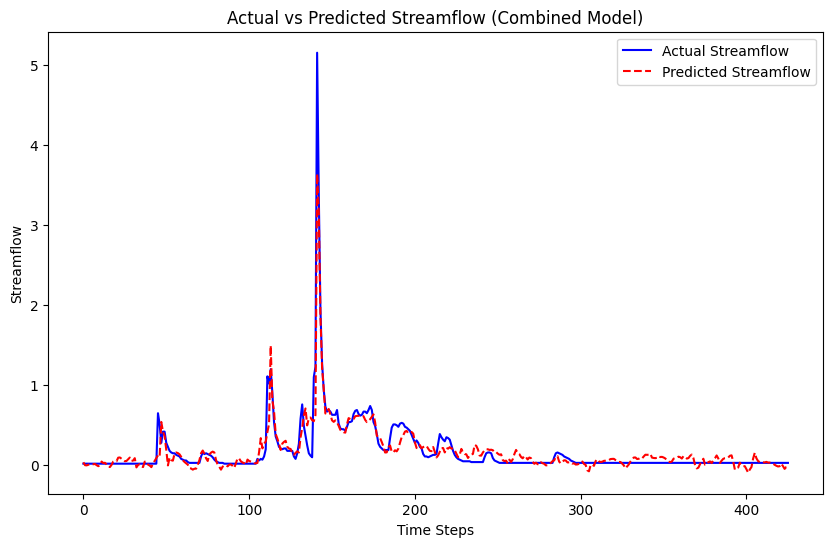

In [130]:
import matplotlib.pyplot as plt

# Plot the actual and predicted streamflow values
plt.figure(figsize=(10, 6))
plt.plot(test_data_y, label='Actual Streamflow', color='blue')
plt.plot(predicted_y, label='Predicted Streamflow', color='red', linestyle='--')

# Adding labels and title
plt.xlabel('Time Steps')
plt.ylabel('Streamflow')
plt.title('Actual vs Predicted Streamflow (Combined Model)')
plt.legend()
# plt.savefig('Combined_Model')|